In [1]:
import CNN2Head_input2 as CNN2Head_input
import tensorflow as tf
import numpy as np
import BKNetStyle2 as BKNetStyle
from const import *

''' PREPARE DATA '''
smile_train, smile_test = CNN2Head_input.getSmileImage()
gender_train, gender_test = CNN2Head_input.getGenderImage()
age_train, age_test = CNN2Head_input.getAgeImage()
'''--------------------------------------------------------------------------------------------'''

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Load smile image...................
Done !
Number of smile train data:  3000
---------------------------------------------------------------
Load gender image...................
Done !
Number of gender train data:  90000
---------------------------------------------------------------
Load age image...................
Done !
Number of age train data:  90000
---------------------------------------------------------------


'--------------------------------------------------------------------------------------------'

In [2]:
def one_hot(index, num_classes):
    assert index < num_classes and index >= 0
    tmp = np.zeros(num_classes, dtype=np.float32)
    tmp[index] = 1.0
    return tmp

In [3]:
sess = tf.InteractiveSession()
x, y_, mask = BKNetStyle.Input()

y_smile_conv, y_gender_conv, y_age_conv, phase_train, keep_prob = BKNetStyle.BKNetModel(x)

In [4]:
print('Restore model')
saver = tf.train.Saver()
saver.restore(sess, SAVE_FOLDER2 + 'model-age101.ckpt')
print('OK')


Restore model
INFO:tensorflow:Restoring parameters from ./save/current2/model-age101.ckpt
OK


In [4]:
smile_loss, gender_loss, age_loss, l2_loss, loss = BKNetStyle.selective_loss(y_smile_conv, y_gender_conv,
                                                                             y_age_conv, y_, mask)
smile_mask = tf.get_collection('smile_mask')[0]
gender_mask = tf.get_collection('gender_mask')[0]
age_mask = tf.get_collection('age_mask')[0]

y_smile = tf.get_collection('y_smile')[0]
y_gender = tf.get_collection('y_gender')[0]
y_age = tf.get_collection('y_age')[0]

smile_correct_prediction = tf.equal(tf.argmax(y_smile_conv, 1), tf.argmax(y_smile, 1))
gender_correct_prediction = tf.equal(tf.argmax(y_gender_conv, 1), tf.argmax(y_gender, 1))
# age_correct_prediction = tf.equal(tf.argmax(y_age_conv, 1), tf.argmax(y_age, 1))

smile_true_pred = tf.reduce_sum(tf.cast(smile_correct_prediction, dtype=tf.float32) * smile_mask)
gender_true_pred = tf.reduce_sum(tf.cast(gender_correct_prediction, dtype=tf.float32) * gender_mask)
age_mae, update_op = tf.metrics.mean_absolute_error(
    tf.argmax(y_age, 1), tf.argmax(y_age_conv, 1), name="age_mae")
running_vars = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope="age_mae")
running_vars_initializer = tf.variables_initializer(var_list=running_vars)
sess.run(running_vars_initializer)

test_data = []

# Mask: Smile -> 0, Gender -> 1, Age -> 2
for i in range(len(smile_test)):
    img = (smile_test[i % 3000][0] - 128) / 255.0
    label = smile_test[i % 3000][1]
    test_data.append((img, one_hot(label, 101), 0.0))
for i in range(len(gender_test)):
    img = (gender_test[i][0] - 128) / 255.0
    label = (int)(gender_test[i][1])
    test_data.append((img, one_hot(label, 101), 1.0))
for i in range(len(age_test)):
    img = (age_test[i][0] - 128) / 255.0
    label = (int)(age_test[i][1])
    test_data.append((img, one_hot(label, 101), 2.0))
np.random.shuffle(test_data)

print('Restore model')
saver = tf.train.Saver()
saver.restore(sess, SAVE_FOLDER2 + 'model-age101.ckpt')
print('OK')

train_img = []
train_label = []
train_mask = []

for i in range(len(test_data)):
    train_img.append(test_data[i][0])
    train_label.append(test_data[i][1])
    train_mask.append(test_data[i][2])

number_batch = len(test_data) // BATCH_SIZE

smile_nb_true_pred = 0
gender_nb_true_pred = 0

smile_nb_train = 0
gender_nb_train = 0
age_nb_train = 0

for batch in range(number_batch):

    top = batch * BATCH_SIZE
    bot = min((batch + 1) * BATCH_SIZE, len(test_data))
    batch_img = np.asarray(train_img[top:bot])
    batch_label = np.asarray(train_label[top:bot])
    batch_mask = np.asarray(train_mask[top:bot])

    # batch_img = CNN2Head_input.random_crop(batch_img, (48, 48), 10)

    for i in range(BATCH_SIZE):
        if batch_mask[i] == 0.0:
            smile_nb_train += 1
        else:
            if batch_mask[i] == 1.0:
                gender_nb_train += 1
            else:
                age_nb_train += 1

    smile_nb_true_pred += sess.run(smile_true_pred, feed_dict={x: batch_img, y_: batch_label, mask: batch_mask,
                                                               phase_train: False,
                                                               keep_prob: 1})

    gender_nb_true_pred += sess.run(gender_true_pred,
                                    feed_dict={x: batch_img, y_: batch_label, mask: batch_mask,
                                               phase_train: False,
                                               keep_prob: 1})

    sess.run(update_op,
            feed_dict={x: batch_img, y_: batch_label, mask: batch_mask,
                       phase_train: False,
                       keep_prob: 1})

smile_train_accuracy = smile_nb_true_pred * 1.0 / smile_nb_train
gender_train_accuracy = gender_nb_true_pred * 1.0 / gender_nb_train
age_train_error = sess.run(age_mae)

print('\n')
print('Smile task train accuracy: ' + str(smile_train_accuracy * 100))
print('Gender task train accuracy: ' + str(gender_train_accuracy * 100))
print('Age task train error: ' + str(age_train_error))


Restore model
INFO:tensorflow:Restoring parameters from ./save/current2/model-age101.ckpt
OK


Smile task train accuracy: 90.03067484662577
Gender task train accuracy: 90.19381830601093
Age task train error: 21.537926


In [5]:
import cv2

from IPython.display import Image, display
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt

detector = MTCNN()

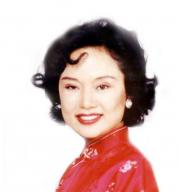

Smile: No 
Gender: Male 
Age: 39


In [38]:
PATH = '/home/ubuntu/coding/cnn/datasets/genki4k/files/file0009.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

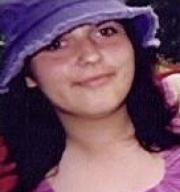

Smile: No 
Gender: Male 
Age: 39


In [42]:
PATH = '/home/ubuntu/coding/cnn/datasets/genki4k/files/file0019.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

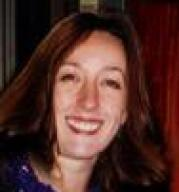

Smile: Yes 
Gender: Male 
Age: 39


In [43]:
PATH = '/home/ubuntu/coding/cnn/datasets/genki4k/files/file0010.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

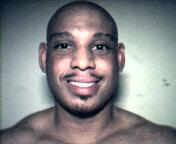

Smile: No 
Gender: Male 
Age: 39


In [44]:
PATH = '/home/ubuntu/coding/cnn/datasets/genki4k/files/file0011.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

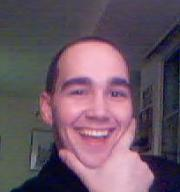

Smile: No [[0.7237076  0.27629235]]
Gender: Male 
Age: 39


In [47]:
PATH = '/home/ubuntu/coding/cnn/datasets/genki4k/files/file0012.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label + str(predict_y_smile_conv))
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

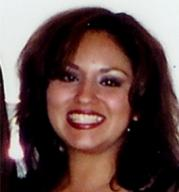

Smile: No 
Gender: Male 
Age: 39


In [46]:
PATH = '/home/ubuntu/coding/cnn/datasets/genki4k/files/file0013.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

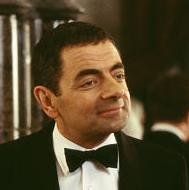

Smile: No 
Gender: Male 
Age: 39


In [39]:
PATH = '/home/ubuntu/coding/cnn/datasets/imdb_crop/00/nm0000100_rm3653409024_1955-1-6_2003.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

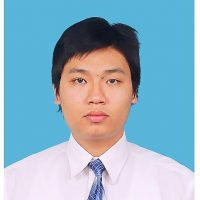

Smile: No 
Gender: Male 
Age: 31


In [13]:
PATH = '/home/ubuntu/coding/cnn/datasets/soict/anhdt.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

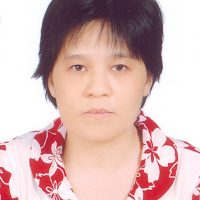

Smile: Yes 
Gender: Female 
Age: 39


In [14]:
PATH = '/home/ubuntu/coding/cnn/datasets/soict/anhnk.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

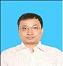

Smile: No 
Gender: Male 
Age: 39


In [15]:
PATH = '/home/ubuntu/coding/cnn/datasets/soict/aphuc.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

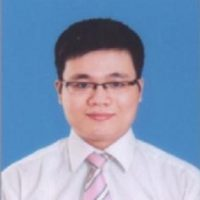

Smile: Yes 
Gender: Male 
Age: 39


In [16]:
PATH = '/home/ubuntu/coding/cnn/datasets/soict/bangbh.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

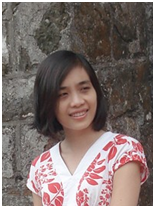

Smile: No 
Gender: Male 
Age: 39


In [18]:
PATH = '/home/ubuntu/coding/cnn/datasets/soict/binhhtt.png'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

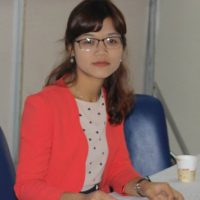

Smile: No 
Gender: Male 
Age: 39


In [19]:
PATH = '/home/ubuntu/coding/cnn/datasets/soict/giangptp.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

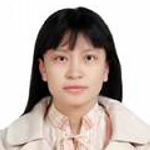

Smile: Yes 
Gender: Male 
Age: 45


In [20]:
PATH = '/home/ubuntu/coding/cnn/datasets/soict/giangvth.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

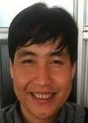

Smile: Yes 
Gender: Male 
Age: 39


In [21]:
PATH = '/home/ubuntu/coding/cnn/datasets/soict/haipd.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

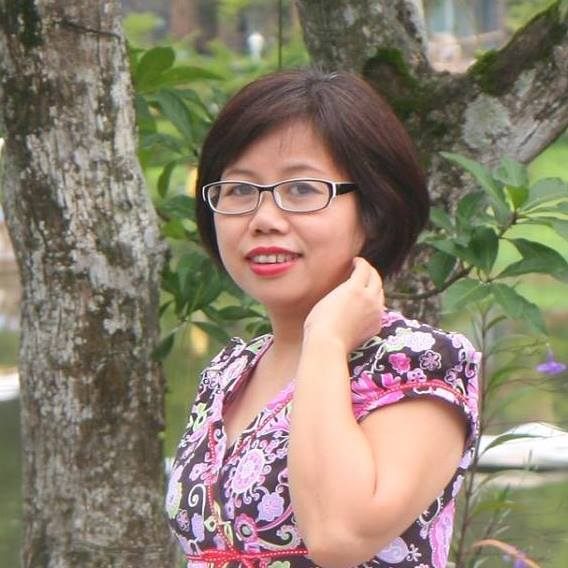

Smile: No 
Gender: Male 
Age: 39


In [23]:
PATH = '/home/ubuntu/coding/cnn/datasets/soict/hiennt.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

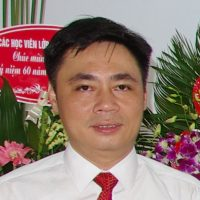

Smile: No 
Gender: Male 
Age: 39


In [24]:
PATH = '/home/ubuntu/coding/cnn/datasets/soict/hoangph.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

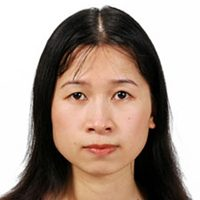

Smile: Yes 
Gender: Female 
Age: 36


In [40]:
PATH = '/home/ubuntu/coding/cnn/datasets/soict/huonglt.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

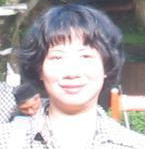

Smile: Yes 
Gender: Male 
Age: 39


In [26]:
PATH = '/home/ubuntu/coding/cnn/datasets/soict/huongntt.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

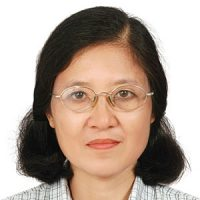

Smile: Yes 
Gender: Male 
Age: 39


In [41]:
PATH = '/home/ubuntu/coding/cnn/datasets/soict/lannth.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

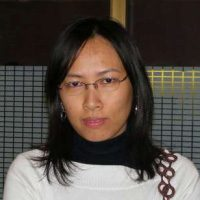

Smile: No 
Gender: Male 
Age: 39


In [28]:
PATH = '/home/ubuntu/coding/cnn/datasets/soict/linh.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

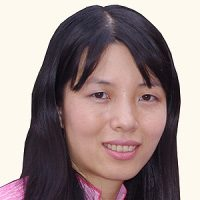

Smile: Yes 
Gender: Male 
Age: 39


In [29]:
PATH = '/home/ubuntu/coding/cnn/datasets/soict/maibtq.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

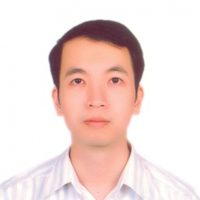

Smile: Yes 
Gender: Male 
Age: 39


In [31]:
PATH = '/home/ubuntu/coding/cnn/datasets/soict/phuongnh.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

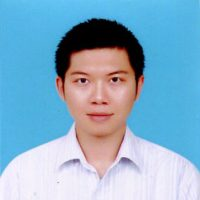

Smile: No 
Gender: Male 
Age: 39


In [32]:
PATH = '/home/ubuntu/coding/cnn/datasets/soict/sangdv.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

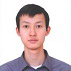

Smile: No 
Gender: Male 
Age: 39


In [33]:
PATH = '/home/ubuntu/coding/cnn/datasets/soict/thuandp.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

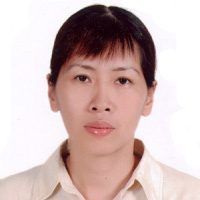

Smile: Yes 
Gender: Male 
Age: 39


In [34]:
PATH = '/home/ubuntu/coding/cnn/datasets/soict/thunq.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

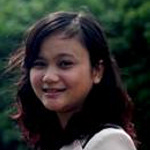

Smile: No 
Gender: Male 
Age: 39


In [35]:
PATH = '/home/ubuntu/coding/cnn/datasets/soict/trangntt.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))

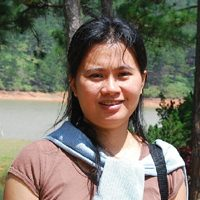

Smile: Yes 
Gender: Female 
Age: 39


In [36]:
PATH = '/home/ubuntu/coding/cnn/datasets/soict/trinhvt.jpg'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(48, 48))

img = (img - 128) / 255.0
T = np.zeros([48, 48, 1])
T[:, :, 0] = img
test_img = []
test_img.append(T)
test_img = np.asarray(test_img)

display(Image(filename = PATH, width=100, height=100))

predict_y_smile_conv = sess.run(y_smile_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_gender_conv = sess.run(y_gender_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})
predict_y_age_conv = sess.run(y_age_conv, feed_dict={x: test_img, phase_train: False, keep_prob: 1})

smile_label = "No " if np.argmax(predict_y_smile_conv)==0 else "Yes "
gender_label = "Female " if np.argmax(predict_y_gender_conv)==0 else "Male "

print('Smile: ' + smile_label)
print('Gender: ' + gender_label)
print('Age: ' + str(np.argmax(predict_y_age_conv)))